In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

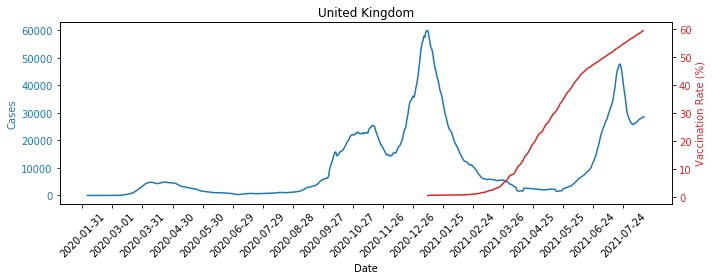

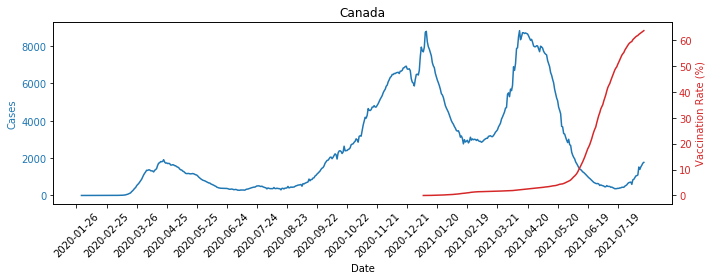

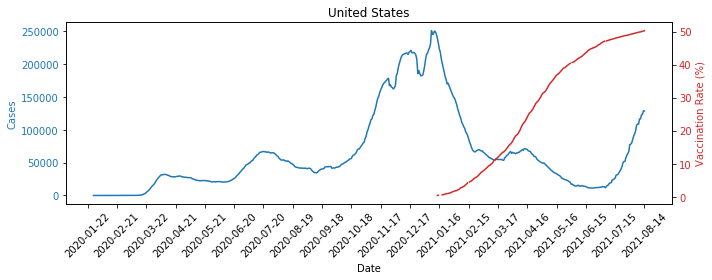

In [2]:
df_country = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')

country = {
    'GBR':'United Kingdom',
    'CAN':'Canada',
    'USA':'United States'
}

for k,v in country.items():
    df_plot = df_country.query(f'iso_code == "{k}"').set_index('date')

    # Create some mock data
    t = range(df_plot.shape[0])
    data1 = df_plot['new_cases_smoothed']#.rolling(7).mean()
    data2 = df_plot['people_fully_vaccinated_per_hundred']#.rolling(7).mean()


    fig, ax1 = plt.subplots(figsize=(10,4))

    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cases', color=color)
    ax1.plot(t, data1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax1.set_xticks(t[::30])
    ax1.set_xticklabels(df_plot.index[::30])
    plt.xticks(rotation=45)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('Vaccination Rate (%)', color=color)  # we already handled the x-label with ax1
    ax2.plot(t, data2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title(country[k])
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    

In [3]:
df_state_name = pd.read_csv('../data/us_state_names.csv').set_index('state')
df_state_name.head()

,state_name
state,
AL,Alabama
AK,Alaska
AZ,Arizona
AR,Arkansas
CA,California


In [4]:
df_pop = pd.read_csv('../data/state_population.csv')
df_pop = df_pop.set_index('state').dropna()

df_pop.head()

,pop_per_sqr_mile,population
state,,
AL,95,"4,858,979"
AK,1,"738,432"
AZ,60,"6,828,065"
AR,57,"2,978,204"
CA,251,"39,144,818"


In [5]:
df_pop = df_state_name.join(df_pop).dropna()
df_pop['population'] = df_pop['population'].apply(lambda x: int(x.replace(',', '')))

df_politics = pd.read_csv('../data/1976-2020-president.csv').query('year == 2020')
df_politics['pct_vote'] = df_politics['candidatevotes']/df_politics['totalvotes']
df_dem = df_politics.query('party_detailed == "DEMOCRAT"')[['state_po', 'pct_vote']]#.set_index('state_po')
df_rep = df_politics.query('party_detailed == "REPUBLICAN"')[['state_po', 'pct_vote']]#.set_index('state_po')
df_pol = df_dem.merge(df_rep, on='state_po', suffixes=['_dem', '_rep']).set_index('state_po')
df_pol.head()

,pct_vote_dem,pct_vote_rep
state_po,,
AL,0.365700,0.620316
AK,0.427720,0.528331
AZ,0.493647,0.490560
AR,0.347751,0.623957
CA,0.634839,0.343207


In [6]:
df = df_pop.join(df_pol)
df['party'] = (df['pct_vote_dem'] > df['pct_vote_rep']).apply(lambda x: 'DEM' if x == True else 'REP')
df.head()

,state_name,pop_per_sqr_mile,population,pct_vote_dem,pct_vote_rep,party
state,,,,,,
AL,Alabama,95,4858979,0.365700,0.620316,REP
AK,Alaska,1,738432,0.427720,0.528331,REP
AZ,Arizona,60,6828065,0.493647,0.490560,DEM
AR,Arkansas,57,2978204,0.347751,0.623957,REP
CA,California,251,39144818,0.634839,0.343207,DEM


In [7]:
# load historical
df_vax_ts = pd.read_csv('../data/COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv', parse_dates=['Date'])
df_vax_ts.columns = [x.lower() for x in df_vax_ts.columns]

# # add new data
# df_vax_ts_ = pd.read_json('https://data.cdc.gov/resource/unsk-b7fc.json')
# df_vax_ts_.columns = df_vax_ts.columns
# df_vax_ts['date'] = pd.to_datetime(df_vax_ts['date'])

# # de-dupe
# df_vax_ts = pd.concat([df_vax_ts, df_vax_ts_]).groupby(['location', 'date']).mean().reset_index()

df_vax_ts = df_vax_ts[['date','location', 'series_complete_yes']].rename(columns={'location':'state'})
df_vax_ts['date'] = pd.to_datetime(df_vax_ts['date']) 
df_vax_ts = df_vax_ts.set_index(['state', 'date'])
df_vax_ts.head()

,,series_complete_yes
state,date,
DC,2021-08-13,395147
IL,2021-08-13,6269965
MH,2021-08-13,17808
VT,2021-08-13,417479
IA,2021-08-13,1588148


In [8]:
df_death = pd.read_csv('../data/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')

# df_death_ = pd.read_json('https://data.cdc.gov/resource/9mfq-cb36.json')
# df_death = pd.concat([df_death, df_death_]).groupby(['state', 'submission_date']).mean().reset_index()

df_death['state'] = df_death['state'].apply(lambda x: 'NY' if x=='NYC' else x)
df_death = df_death.groupby(['state', 'submission_date']).sum().reset_index()

df_death['submission_date'] = pd.to_datetime(df_death['submission_date'])
df_death = df_death.set_index('submission_date')

df_death_ts = df_death.reset_index().rename(columns={'submission_date':'date'})
df_death_ts['date'] = pd.to_datetime(df_death_ts['date']) 

df_death_ts = df_death_ts.reset_index().set_index('state')

df_death_ts = df_death_ts.reset_index().groupby(['state', 'date']).mean()
df_death_ts.head()

index  tot_cases  conf_cases  prob_cases  new_case  \
state date                                                             
AK    2020-01-22     21          0         0.0         0.0         0   
      2020-01-23     23          0         0.0         0.0         0   
      2020-01-24     25          0         0.0         0.0         0   
      2020-01-25     27          0         0.0         0.0         0   
      2020-01-26     29          0         0.0         0.0         0   

                  pnew_case  tot_death  conf_death  prob_death  new_death  \
state date                                                                  
AK    2020-01-22        0.0          0         0.0         0.0          0   
      2020-01-23        0.0          0         0.0         0.0          0   
      2020-01-24        0.0          0         0.0         0.0          0   
      2020-01-25        0.0          0         0.0         0.0          0   
      2020-01-26        0.0          0         0.0         0.0          0   

                  pnew_death  
state date                    
AK    2020-01-22         0.0  
      2020-01-23         0.0  
      2020-01-24         0.0  
      2020-01-25         0.0  
      2020-01-26         0.0

In [9]:
df_ts = df_vax_ts.join(df_death_ts).join(df[['population', 'pop_per_sqr_mile', 'party', 'pct_vote_rep', 'state_name']])
df_ts['death_per_100K'] = 100_000*df_ts['tot_death']/df_ts['population']
df_ts['vax_rate'] = 100*df_ts['series_complete_yes']/df_ts['population'].fillna(0)


In [10]:
df_ts = df_ts.sort_index()
df_30d = df_ts.groupby(['state'])[['tot_death']].diff().rename(columns={'tot_death':'new_death'}).groupby('state').rolling(14).sum()[['new_death']].rename(columns={'new_death':'new_death_30d'}).fillna(0)
df_30d.index.names = ['', 'state', 'date']
df_ts_1 = df_ts.join(df_30d)
df_ts_1['new_death_30d_per_100K'] = 100_000*df_ts_1['new_death_30d']/df_ts_1['population']

df_ts_1 = df_ts_1[['vax_rate', 'death_per_100K', 'new_death_30d_per_100K', 'party', 'pop_per_sqr_mile', 'pct_vote_rep', 'state_name']].drop_duplicates()
df_ts_1.head()

vax_rate  death_per_100K  new_death_30d_per_100K party  \
state date                                                                    
AK    2020-12-14 AK       0.0       35.074320                     0.0   REP   
      2020-12-15 AK       0.0       35.480586                     0.0   REP   
      2020-12-16 AK       0.0       35.616008                     0.0   REP   
      2020-12-17 AK       0.0       35.886852                     0.0   REP   
      2020-12-18 AK       0.0       36.022274                     0.0   REP   

                     pop_per_sqr_mile  pct_vote_rep state_name  
state date                                                      
AK    2020-12-14 AK               1.0      0.528331     Alaska  
      2020-12-15 AK               1.0      0.528331     Alaska  
      2020-12-16 AK               1.0      0.528331     Alaska  
      2020-12-17 AK               1.0      0.528331     Alaska  
      2020-12-18 AK               1.0      0.528331     Alaska

In [11]:
# dts = pd.date_range('2021-08-10', '2021-08-12')
# states = ['FL', 'TX', 'CA', 'NJ', 'NY']

# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,16))

# def animate(i):
#     ax1.cla()
#     ax1.set_xlim(-5,120)
#     ax1.set_ylim(-5,20)
#     dt = dts[i]
#     df_plot_ts = df_ts_1.xs(dt, level=1, drop_level=False).reset_index().dropna().set_index('state').drop('DC', errors='ignore').drop_duplicates()

#     x='vax_rate'
#     y='new_death_30d_per_100K'
#     #y='death_per_100K' 
#     palette={'DEM':'blue', 'REP':'red'}
    
#     df_plot_ts = df_plot_ts.rename(columns={
#         'pop_per_sqr_mile':'population / mi^2',
#         'pct_vote_rep':'Republican\nvote share'
#     })
    
#     sns.scatterplot(
#         data=df_plot_ts, 
#         x=x, 
#         y=y,
#         hue='Republican\nvote share',
#         size='population / mi^2',
#         sizes=(50,250),
#         palette='coolwarm',
#         alpha=0.95,
#         ax=ax1,
#         #legend=False
#     )
    
#     circle_rad = 10
#     ax1.text(0,-4, dt.strftime('%Y-%m-%d'))
#     for st in states:
#         ax1.text(
#             df_plot_ts.loc[st][x]*1.015, 
#             df_plot_ts.loc[st][y]*1.015, 
#             df_plot_ts.loc[st]['state_name']
#         )
        
#         ax1.plot(
#             df_plot_ts.loc[st][x], 
#             df_plot_ts.loc[st][y], 
#             'o', ms=circle_rad*2, 
#             mec='k', 
#             mfc='none', 
#             mew=1
#         )
        
#     ax1.set_ylabel(f'Last 30 days deaths/100K')
#     ax1.set_xlabel('Vaccination rate (%)')
#     ax1.set_title('USA covid-19 deaths, vaccination & politics')
#     ax1.hlines(0,-5,120, linestyle='--', color='grey')
#     ax1.vlines(100,-5,20, linestyle='--', color='grey')
    
#     ax2.cla()
#     ax2.set_xlim(-5,120)
#     ax2.set_ylim(-50,350)
#     ax2.hlines(0,-5,120, linestyle='--', color='grey')
#     ax2.vlines(100,-50,350, linestyle='--', color='grey')
    
#     x='vax_rate'
#     y='death_per_100K' 
#     palette={'DEM':'blue', 'REP':'red'}
    
#     p = sns.scatterplot(
#         data=df_plot_ts,
#         x=x, 
#         y=y,
#         hue='Republican\nvote share',
#         size='population / mi^2',
#         sizes=(50,250),
#         palette='coolwarm',
#         alpha=0.95,
#         ax=ax2,
#         legend=False
#     )
    
#     circle_rad = 10
#     ax2.text(0,10, dt.strftime('%Y-%m-%d'))
#     for st in states:
        
#         ax2.text(
#             df_plot_ts.loc[st][x]*1.015, 
#             df_plot_ts.loc[st][y]*1.015, 
#             df_plot_ts.loc[st]['state_name']
#         )
        
#         ax2.plot(
#             df_plot_ts.loc[st][x], 
#             df_plot_ts.loc[st][y], 
#             'o', ms=circle_rad*2, 
#             mec='k', 
#             mfc='none', 
#             mew=1
#         )
        
#     ax2.set_ylabel(f'Cumulative deaths/100K')
#     ax2.set_xlabel('Vaccination rate (%)')
    
#     ax3.cla()
#     ax3.set_ylim(0,260_000)
    
#     df_plot = df_country.query(f'iso_code == "USA"').set_index('date')
#     t = range(df_plot.shape[0])
#     df_plot['t'] = t
#     data1 = df_plot['new_cases_smoothed']#.rolling(7).mean()
#     df_plot['vax_rate_plot'] = df_plot['people_fully_vaccinated_per_hundred']*df_plot['new_cases_smoothed'].max()*1.75/100
    
#     color = 'black'#'tab:blue'
#     ax3.set_xlabel('Date')
#     ax3.set_ylabel('USA covid-19 cases', color=color)
#     ax3.plot(t, data1, color='grey')
#     ax3.plot(t, df_plot['vax_rate_plot'], color='tab:blue')
#     ax3.plot(df_plot.loc[dt.strftime('%Y-%m-%d'), ['t']], df_plot.loc[dt.strftime('%Y-%m-%d'), ['new_cases_smoothed']], 'o', ms=10, alpha=0.5, color='grey')
#     ax3.plot(df_plot.loc[dt.strftime('%Y-%m-%d'), ['t']], df_plot.loc[dt.strftime('%Y-%m-%d'), ['vax_rate_plot']], 'o', ms=10, alpha=0.5, color='tab:blue')
#     ax3.tick_params(axis='y', labelcolor=color)
#     ax3.set_xticks(t[::30])
#     ax3.set_xticklabels(df_plot.index[::30], rotation = 45)
    
#     ax3.text(
#         df_plot.loc[dt.strftime('%Y-%m-%d'), ['t']]*1.015, 
#         df_plot.loc[dt.strftime('%Y-%m-%d'), ['vax_rate_plot']]*1.015, 
#         f"Vaccination rate\n{df_plot.loc[dt.strftime('%Y-%m-%d')]['people_fully_vaccinated_per_hundred']} %"
#     )
        
# # Set up formatting for the movie files
# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
    
# interval=25
# ani = animation.FuncAnimation(fig, animate, frames=len(dts),interval=interval,repeat=False, repeat_delay=5000)
# ani.save(f'../plots/usa_covid_i{interval}.mp4', writer=writer)


## Canada COVID

In [12]:
df_can_vax_ = pd.read_csv('https://health-infobase.canada.ca/src/data/covidLive/vaccination-coverage-map.csv')
df_can_vax_.columns

Index(['week_end', 'pruid', 'prename', 'prfname', 'numtotal_atleast1dose',
       'numtotal_partially', 'numtotal_fully', 'proptotal_atleast1dose',
       'proptotal_partially', 'proptotal_fully', 'numeligible_atleast1dose',
       'numeligible_partially', 'numeligible_fully',
       'propeligible_atleast1dose', 'propeligible_partially',
       'propeligible_fully', 'numweekdelta_atleast1dose', 'numweekdelta_fully',
       'propweekdelta_atleast1dose', 'propweekdelta_fully'],
      dtype='object')

In [13]:
df_can_death_ = pd.read_csv('https://health-infobase.canada.ca/src/data/covidLive/covid19-download.csv')

In [15]:
df_can_death = df_can_death_[['prname', 'date', 'numdeaths', 'numdeaths_last7', 'ratedeaths', 'ratedeaths_last14']].fillna(0).set_index(['prname', 'date']).sort_index()

In [16]:
from datetime import datetime, timedelta

df_can_death['week_end'] = [pd.to_datetime(x) - timedelta(days=pd.to_datetime(x).weekday()) + timedelta(days=5) for x in df_can_death.index.get_level_values(1)]

In [17]:
df_can_death

numdeaths  numdeaths_last7  ratedeaths  ratedeaths_last14  \
prname  date                                                                    
Alberta 2020-03-08        0.0              0.0        0.00               0.00   
        2020-03-09        0.0              0.0        0.00               0.00   
        2020-03-11        0.0              0.0        0.00               0.00   
        2020-03-12        0.0              0.0        0.00               0.00   
        2020-03-13        0.0              0.0        0.00               0.00   
...                       ...              ...         ...                ...   
Yukon   2021-08-10        8.0              0.0       19.02               4.76   
        2021-08-11        8.0              0.0       19.02               4.76   
        2021-08-12        8.0              0.0       19.02               4.76   
        2021-08-13        8.0              0.0       19.02               2.38   
        2021-08-14        8.0              0.0       19.02               2.38   

                     week_end  
prname  date                   
Alberta 2020-03-08 2020-03-07  
        2020-03-09 2020-03-14  
        2020-03-11 2020-03-14  
        2020-03-12 2020-03-14  
        2020-03-13 2020-03-14  
...                       ...  
Yukon   2021-08-10 2021-08-14  
        2021-08-11 2021-08-14  
        2021-08-12 2021-08-14  
        2021-08-13 2021-08-14  
        2021-08-14 2021-08-14  

[7887 rows x 5 columns]

In [18]:
df_can_vax = df_can_vax_[['prename', 'week_end', 'numtotal_fully', 'numtotal_partially', 'proptotal_atleast1dose',
       'proptotal_partially', 'proptotal_fully']].rename(
    columns={'week_end':'date', 'prename':'prname'}
).set_index(['prname', 'date']).sort_index()

df_can_vax

numtotal_fully  numtotal_partially  \
prname  date                                             
Alberta 2020-12-26             0.0              4792.0   
        2021-01-02             0.0             13383.0   
        2021-01-09           724.0             43574.0   
        2021-01-16          4075.0             77784.0   
        2021-01-23          9469.0             80088.0   
...                            ...                 ...   
Yukon   2021-07-10         28110.0              2952.0   
        2021-07-17         28684.0              2622.0   
        2021-07-24         29169.0              2333.0   
        2021-07-31         29473.0              2257.0   
        2021-08-07         29843.0              2096.0   

                    proptotal_atleast1dose  proptotal_partially  \
prname  date                                                      
Alberta 2020-12-26                    0.11                 0.11   
        2021-01-02                    0.30                 0.30   
        2021-01-09                    1.00                 0.99   
        2021-01-16                    1.85                 1.76   
        2021-01-23                    2.03                 1.81   
...                                    ...                  ...   
Yukon   2021-07-10                   73.87                 7.02   
        2021-07-17                   74.45                 6.24   
        2021-07-24                   74.91                 5.55   
        2021-07-31                   75.45                 5.37   
        2021-08-07                   75.95                 4.98   

                    proptotal_fully  
prname  date                         
Alberta 2020-12-26             0.00  
        2021-01-02             0.00  
        2021-01-09             0.02  
        2021-01-16             0.09  
        2021-01-23             0.21  
...                             ...  
Yukon   2021-07-10            66.85  
        2021-07-17            68.21  
        2021-07-24            69.36  
        2021-07-31            70.09  
        2021-08-07            70.97  

[469 rows x 5 columns]

In [19]:
df_can_pop_ = pd.read_csv('../data/cananda_population.csv')
df_can_pop = df_can_pop_.dropna().iloc[:,[1,3,11]]
df_can_pop.columns = ['prname', 'population', 'pop_per_sqr_km']
df_can_pop = df_can_pop.set_index('prname')
df_can_pop

,population,pop_per_sqr_km
prname,,
Canada,33476688.0,3.7341
Ontario,12851821.0,14.1445
Quebec,7903001.0,5.8258
British Columbia,4400057.0,4.7697
Alberta,3645257.0,5.6950
Manitoba,1208268.0,2.1876
Saskatchewan,1033381.0,1.7567
Nova Scotia,921727.0,17.4110
New Brunswick,751171.0,10.5240


In [20]:
df_can_pol_ = pd.read_csv('../data/can_election_2019.csv').dropna().replace('–', 0)[['prname','lib','con', 'ndp', 'total']]
for col in ['lib', 'con', 'ndp', 'total']:
    df_can_pol_[col] = df_can_pol_[col].apply(lambda x: int(x.replace(',', '')))

df_can_pol = df_can_pol_.groupby('prname').sum()

for col in ['lib', 'con', 'ndp']:
    df_can_pol[col+'_pct'] = df_can_pol[col]/df_can_pol['total']

df_can_pol.index.name = 'pr'

pr_name_map = {
     'AB': 'Alberta'
    ,'BC': 'British Columbia'
    ,'MB': 'Manitoba'
    ,'NB': 'New Brunswick'
    ,'NL': 'Newfoundland and Labrador'
    ,'NS': 'Nova Scotia'
    ,'ON': 'Ontario'
    ,'PE': 'Prince Edward Island'
    ,'QC': 'Quebec'
    ,'SK': 'Saskatchewan'
    ,'Terr1':'Northwest Territories'
    ,'Terr2':'Yukon'
    ,'Terr3':'Nunavut'
}

df_pr_name_map = pd.DataFrame.from_dict(pr_name_map, orient='index', columns=['prname'])
df_pr_name_map.index.name = 'pr'
df_pr_name_map = df_pr_name_map.reset_index()
df_pr_name_map['pr'] = df_pr_name_map['pr'].apply(lambda x: 'Terr' if x.startswith('Terr') else x)

df_can_pol = df_pr_name_map.merge(df_can_pol, on='pr', how='left').drop(columns=['pr']).set_index('prname')
df_can_pol

,lib,con,ndp,total,lib_pct,con_pct,ndp_pct
prname,,,,,,,
Alberta,288010,1438233,241376,2082961,0.138270,0.690475,0.115881
British Columbia,624689,811490,583437,2387766,0.261621,0.339853,0.244344
Manitoba,156727,267811,123331,592239,0.264635,0.452201,0.208245
New Brunswick,164970,144229,41212,439810,0.375094,0.327935,0.093704
Newfoundland and Labrador,109148,67962,57664,243278,0.448655,0.279359,0.237029
Nova Scotia,221087,137300,100853,533922,0.414081,0.257154,0.188891
Ontario,2863719,2277937,1158696,6892217,0.415500,0.330509,0.168117
Prince Edward Island,29284,16387,5214,65116,0.449720,0.251659,0.080072
Quebec,1468603,684661,464414,4284338,0.342784,0.159806,0.108398


In [21]:
df_can = df_can_death.join(df_can_vax)

df_can_pr = {}
for pr in df_can.index.get_level_values(0).unique():
    df_can_pr[pr] = df_can.loc[pr].interpolate()

df_can_interp = pd.concat(df_can_pr).fillna(0)
df_can_interp.index.names = ['prname', 'date']
df_can_interp

numdeaths  numdeaths_last7  ratedeaths  ratedeaths_last14  \
prname  date                                                                    
Alberta 2020-03-08        0.0              0.0        0.00               0.00   
        2020-03-09        0.0              0.0        0.00               0.00   
        2020-03-11        0.0              0.0        0.00               0.00   
        2020-03-12        0.0              0.0        0.00               0.00   
        2020-03-13        0.0              0.0        0.00               0.00   
...                       ...              ...         ...                ...   
Yukon   2021-08-10        8.0              0.0       19.02               4.76   
        2021-08-11        8.0              0.0       19.02               4.76   
        2021-08-12        8.0              0.0       19.02               4.76   
        2021-08-13        8.0              0.0       19.02               2.38   
        2021-08-14        8.0              0.0       19.02               2.38   

                     week_end  numtotal_fully  numtotal_partially  \
prname  date                                                        
Alberta 2020-03-08 2020-03-07             0.0                 0.0   
        2020-03-09 2020-03-14             0.0                 0.0   
        2020-03-11 2020-03-14             0.0                 0.0   
        2020-03-12 2020-03-14             0.0                 0.0   
        2020-03-13 2020-03-14             0.0                 0.0   
...                       ...             ...                 ...   
Yukon   2021-08-10 2021-08-14         29843.0              2096.0   
        2021-08-11 2021-08-14         29843.0              2096.0   
        2021-08-12 2021-08-14         29843.0              2096.0   
        2021-08-13 2021-08-14         29843.0              2096.0   
        2021-08-14 2021-08-14         29843.0              2096.0   

                    proptotal_atleast1dose  proptotal_partially  \
prname  date                                                      
Alberta 2020-03-08                    0.00                 0.00   
        2020-03-09                    0.00                 0.00   
        2020-03-11                    0.00                 0.00   
        2020-03-12                    0.00                 0.00   
        2020-03-13                    0.00                 0.00   
...                                    ...                  ...   
Yukon   2021-08-10                   75.95                 4.98   
        2021-08-11                   75.95                 4.98   
        2021-08-12                   75.95                 4.98   
        2021-08-13                   75.95                 4.98   
        2021-08-14                   75.95                 4.98   

                    proptotal_fully  
prname  date                         
Alberta 2020-03-08             0.00  
        2020-03-09             0.00  
        2020-03-11             0.00  
        2020-03-12             0.00  
        2020-03-13             0.00  
...                             ...  
Yukon   2021-08-10            70.97  
        2021-08-11            70.97  
        2021-08-12            70.97  
        2021-08-13            70.97  
        2021-08-14            70.97  

[7887 rows x 10 columns]

In [22]:
df_can_covid = df_can_interp.join(df_can_pop).join(df_can_pol)

In [23]:
df_can_covid.xs('2021-08-14', level=1, drop_level=False).dropna().shape

(13, 19)

In [24]:
# dts = pd.date_range('2021-01-31', '2021-08-13')
# provinces = ['Ontario', 'British Columbia', 'Quebec', 'Alberta']#pr_name_map.values()

# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,16))

# def animate(i):
#     dt = dts[i]
#     df_plot_ts = df_can_covid.xs(dt.strftime('%Y-%m-%d'), level=1, drop_level=False).dropna().rename(
#         columns={
#             'con_pct':'conservative\nvote share',
#             'pop_per_sqr_km':'pop. density\n(per km^2)',
#             'population':'population (MM)'
#         }
#     )
#     df_plot_ts['population (MM)'] = df_plot_ts['population (MM)']/1_000_000

#     x='proptotal_atleast1dose'
#     y='ratedeaths_last14'

#     ax1.cla()
#     ax1.set_xlim(0,120)
#     ax1.set_ylim(-1,3)
#     sns.scatterplot(
#         x=x,
#         y=y,
#         size='population (MM)',
#         sizes=(50,500),
#         hue='conservative\nvote share',
#         palette='coolwarm',
#         data=df_plot_ts,
#         ax=ax1
#     )
#     #ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     ax1.legend(loc='upper right', ncol=2)
#     #ax1._legend.set_title('new_title')
    
#     ax1.hlines(0,0,120, linestyle='--', color='grey')
#     ax1.vlines(100,-1,3, linestyle='--', color='grey')
#     circle_rad = 10
#     ax1.text(5,-.5, dt.strftime('%Y-%m-%d'))
#     for pr in provinces:
#         ax1.text(
#             df_plot_ts.loc[pr][x][0]*1.05, 
#             df_plot_ts.loc[pr][y]*1.05, 
#             pr.replace(' ', '\n')
#         )

#         ax1.plot(
#             df_plot_ts.loc[pr][x][0], 
#             df_plot_ts.loc[pr][y][0], 
#             'o', ms=circle_rad*2, 
#             mec='k', 
#             mfc='none', 
#             mew=1
#         )
#     ax1.set_xlabel('Vaccination rate (%)\nat least one dose')
#     ax1.set_ylabel('Last 14 days\ndeaths/100K ')
#     ax1.set_title('Canada covid-19 deaths, vaccination & politics')
    
#     ax2.cla()
#     ax2.set_xlim(0,120)
#     ax2.set_ylim(-20,150)
#     ax2.hlines(0,0,140, linestyle='--', color='grey')
#     ax2.vlines(100,-20,150, linestyle='--', color='grey')

#     x='proptotal_atleast1dose'
#     y='ratedeaths'

#     sns.scatterplot(
#         x=x,
#         y=y,
#         size='population (MM)',
#         sizes=(50,500),
#         hue='conservative\nvote share',
#         palette='coolwarm',
#         data=df_plot_ts,
#         ax=ax2,
#         legend=False
#     )
#     #ax2.set_xlabel('')
#     ax2.set_xlabel('Vaccination rate (%)\nat least one dose')
#     ax2.set_ylabel('Cumulative\ndeaths/100K ')

#     for pr in provinces:
#         ax2.text(
#             df_plot_ts.loc[pr][x][0]*1.05, 
#             df_plot_ts.loc[pr][y]*1.05, 
#             pr.replace(' ', '\n')
#         )

#         ax2.plot(
#             df_plot_ts.loc[pr][x][0], 
#             df_plot_ts.loc[pr][y][0], 
#             'o', ms=circle_rad*2, 
#             mec='k', 
#             mfc='none', 
#             mew=1
#         )


#     ax3.cla()
#     ax3.set_ylim(0,12_000)

#     df_plot = df_country.query(f'iso_code == "CAN"').set_index('date')
#     t = range(df_plot.shape[0])
#     df_plot['t'] = t
#     data1 = df_plot['new_cases_smoothed']#.rolling(7).mean()
#     df_plot['vax_rate_plot'] = df_plot['people_fully_vaccinated_per_hundred']*df_plot['new_cases_smoothed'].max()*1.75/100

#     color = 'black'#'tab:blue'
#     ax3.set_xlabel('Date')
#     ax3.set_ylabel('Canada covid-19 cases', color=color)
#     ax3.plot(t, data1, color='grey')
#     ax3.plot(t, df_plot['vax_rate_plot'], color='tab:blue')
#     ax3.plot(df_plot.loc[dt.strftime('%Y-%m-%d'), ['t']], df_plot.loc[dt.strftime('%Y-%m-%d'), ['new_cases_smoothed']], 'o', ms=10, alpha=0.5, color='grey')
#     ax3.plot(df_plot.loc[dt.strftime('%Y-%m-%d'), ['t']], df_plot.loc[dt.strftime('%Y-%m-%d'), ['vax_rate_plot']], 'o', ms=10, alpha=0.5, color='tab:blue')
#     ax3.tick_params(axis='y', labelcolor=color)
#     ax3.set_xticks(t[::30])
#     ax3.set_xticklabels(df_plot.index[::30], rotation = 45)

#     ax3.text(
#         df_plot.loc[dt.strftime('%Y-%m-%d'), ['t']]*1.015, 
#         df_plot.loc[dt.strftime('%Y-%m-%d'), ['vax_rate_plot']]*1.015, 
#         f"Vaccination rate\n{df_plot.loc[dt.strftime('%Y-%m-%d')]['people_fully_vaccinated_per_hundred']} %"
#     );

    
# # Set up formatting for the movie files
# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

# interval=25
# ani = animation.FuncAnimation(fig, animate, frames=len(dts),interval=interval,repeat=False, repeat_delay=5000)
# ani.save(f'../plots/canada_covid_i{interval}.mp4', writer=writer)


In [ ]:
dts = pd.date_range('2021-01-31', '2021-08-13')
provinces = ['Ontario', 'British Columbia', 'Quebec', 'Alberta']#pr_name_map.values()
states = ['FL', 'TX', 'CA', 'NJ', 'NY']


fig, axs = plt.subplots(3,2, figsize=(20,16))

ax1 = axs[0,0]
ax2 = axs[1,0]
ax3 = axs[2,0]
ax4 = axs[0,1]
ax5 = axs[1,1]
ax6 = axs[2,1]

def animate(i):
    dt = dts[i]
    df_plot_ts = df_can_covid.xs(dt.strftime('%Y-%m-%d'), level=1, drop_level=False).dropna().rename(
        columns={
            'con_pct':'conservative\nvote share',
            'pop_per_sqr_km':'pop. density\n(per km^2)',
            'population':'population (MM)'
        }
    )
    df_plot_ts['population (MM)'] = df_plot_ts['population (MM)']/1_000_000

    x='proptotal_atleast1dose'
    y='ratedeaths_last14'

    ax1.cla()
    ax1.set_xlim(0,120)
    ax1.set_ylim(-1,3)
    sns.scatterplot(
        x=x,
        y=y,
        size='population (MM)',
        sizes=(50,500),
        hue='conservative\nvote share',
        palette='coolwarm',
        data=df_plot_ts,
        ax=ax1
    )
    #ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax1.legend(loc='upper right', ncol=2)
    #ax1._legend.set_title('new_title')
    
    ax1.hlines(0,0,120, linestyle='--', color='grey')
    ax1.vlines(100,-1,3, linestyle='--', color='grey')
    circle_rad = 10
    ax1.text(5,-.5, dt.strftime('%Y-%m-%d'))
    for pr in provinces:
        ax1.text(
            df_plot_ts.loc[pr][x][0]*1.05, 
            df_plot_ts.loc[pr][y]*1.05, 
            pr.replace(' ', '\n')
        )

        ax1.plot(
            df_plot_ts.loc[pr][x][0], 
            df_plot_ts.loc[pr][y][0], 
            'o', ms=circle_rad*2, 
            mec='k', 
            mfc='none', 
            mew=1
        )
    ax1.set_xlabel('Vaccination rate (%)\nat least one dose')
    ax1.set_ylabel('Last 14 days\ndeaths/100K ')
    ax1.set_title('Canada')
    
    ax2.cla()
    ax2.set_xlim(0,120)
    ax2.set_ylim(-20,150)
    ax2.hlines(0,0,140, linestyle='--', color='grey')
    ax2.vlines(100,-20,150, linestyle='--', color='grey')

    x='proptotal_atleast1dose'
    y='ratedeaths'

    sns.scatterplot(
        x=x,
        y=y,
        size='population (MM)',
        sizes=(50,500),
        hue='conservative\nvote share',
        palette='coolwarm',
        data=df_plot_ts,
        ax=ax2,
        legend=False
    )
    #ax2.set_xlabel('')
    ax2.set_xlabel('Vaccination rate (%)\nat least one dose')
    ax2.set_ylabel('Cumulative\ndeaths/100K ')

    for pr in provinces:
        ax2.text(
            df_plot_ts.loc[pr][x][0]*1.05, 
            df_plot_ts.loc[pr][y]*1.05, 
            pr.replace(' ', '\n')
        )

        ax2.plot(
            df_plot_ts.loc[pr][x][0], 
            df_plot_ts.loc[pr][y][0], 
            'o', ms=circle_rad*2, 
            mec='k', 
            mfc='none', 
            mew=1
        )


    ax3.cla()
    ax3.set_ylim(0,12_000)

    df_plot = df_country.query(f'iso_code == "CAN"').set_index('date')
    t = range(df_plot.shape[0])
    df_plot['t'] = t
    data1 = df_plot['new_cases_smoothed']#.rolling(7).mean()
    df_plot['vax_rate_plot'] = df_plot['people_fully_vaccinated_per_hundred']*df_plot['new_cases_smoothed'].max()*1.75/100

    color = 'black'#'tab:blue'
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Canada covid-19 cases', color=color)
    ax3.plot(t, data1, color='grey')
    ax3.plot(t, df_plot['vax_rate_plot'], color='tab:blue')
    ax3.plot(df_plot.loc[dt.strftime('%Y-%m-%d'), ['t']], df_plot.loc[dt.strftime('%Y-%m-%d'), ['new_cases_smoothed']], 'o', ms=10, alpha=0.5, color='grey')
    ax3.plot(df_plot.loc[dt.strftime('%Y-%m-%d'), ['t']], df_plot.loc[dt.strftime('%Y-%m-%d'), ['vax_rate_plot']], 'o', ms=10, alpha=0.5, color='tab:blue')
    ax3.tick_params(axis='y', labelcolor=color)
    ax3.set_xticks(t[::30])
    ax3.set_xticklabels(df_plot.index[::30], rotation = 45)

    ax3.text(
        df_plot.loc[dt.strftime('%Y-%m-%d'), ['t']]*1.015, 
        df_plot.loc[dt.strftime('%Y-%m-%d'), ['vax_rate_plot']]*1.015, 
        f"Vaccination rate\n{df_plot.loc[dt.strftime('%Y-%m-%d')]['people_fully_vaccinated_per_hundred']} %"
    );



    ax4.cla()
    ax4.set_xlim(-5,120)
    ax4.set_ylim(-5,10)
    dt = dts[i]
    df_plot_ts = df_ts_1.xs(dt, level=1, drop_level=False).reset_index().dropna().set_index('state').drop('DC', errors='ignore').drop_duplicates()

    x='vax_rate'
    y='new_death_30d_per_100K'
    #y='death_per_100K' 
    palette={'DEM':'blue', 'REP':'red'}
    
    df_plot_ts = df_plot_ts.rename(columns={
        'pop_per_sqr_mile':'population / mi^2',
        'pct_vote_rep':'Republican\nvote share'
    })
    
    sns.scatterplot(
        data=df_plot_ts, 
        x=x, 
        y=y,
        hue='Republican\nvote share',
        size='population / mi^2',
        sizes=(50,250),
        palette='coolwarm',
        alpha=0.95,
        ax=ax4,
        #legend=False
    )
    
    circle_rad = 10
    ax4.text(0,-4, dt.strftime('%Y-%m-%d'))
    for st in states:
        ax4.text(
            df_plot_ts.loc[st][x]*1.015, 
            df_plot_ts.loc[st][y]*1.015, 
            df_plot_ts.loc[st]['state_name']
        )
        
        ax4.plot(
            df_plot_ts.loc[st][x], 
            df_plot_ts.loc[st][y], 
            'o', ms=circle_rad*2, 
            mec='k', 
            mfc='none', 
            mew=1
        )
        
    ax4.set_ylabel(f'Last 14 days\ndeaths/100K')
    ax4.set_xlabel('Vaccination rate (%)')
    ax4.set_title('USA')
    ax4.hlines(0,-5,120, linestyle='--', color='grey')
    ax4.vlines(100,-5,20, linestyle='--', color='grey')
    
    ax5.cla()
    ax5.set_xlim(-5,120)
    ax5.set_ylim(-50,350)
    ax5.hlines(0,-5,120, linestyle='--', color='grey')
    ax5.vlines(100,-50,350, linestyle='--', color='grey')
    
    x='vax_rate'
    y='death_per_100K' 
    palette={'DEM':'blue', 'REP':'red'}
    
    p = sns.scatterplot(
        data=df_plot_ts,
        x=x, 
        y=y,
        hue='Republican\nvote share',
        size='population / mi^2',
        sizes=(50,250),
        palette='coolwarm',
        alpha=0.95,
        ax=ax5,
        legend=False
    )
    
    circle_rad = 10
    ax5.text(0,10, dt.strftime('%Y-%m-%d'))
    for st in states:
        
        ax5.text(
            df_plot_ts.loc[st][x]*1.015, 
            df_plot_ts.loc[st][y]*1.015, 
            df_plot_ts.loc[st]['state_name']
        )
        
        ax5.plot(
            df_plot_ts.loc[st][x], 
            df_plot_ts.loc[st][y], 
            'o', ms=circle_rad*2, 
            mec='k', 
            mfc='none', 
            mew=1
        )
        
    ax5.set_ylabel(f'Cumulative\ndeaths/100K')
    ax5.set_xlabel('Vaccination rate (%)')
    
    ax6.cla()
    ax6.set_ylim(0,260_000)
    
    df_plot = df_country.query(f'iso_code == "USA"').set_index('date')
    t = range(df_plot.shape[0])
    df_plot['t'] = t
    data1 = df_plot['new_cases_smoothed']#.rolling(7).mean()
    df_plot['vax_rate_plot'] = df_plot['people_fully_vaccinated_per_hundred']*df_plot['new_cases_smoothed'].max()*1.75/100
    
    color = 'black'#'tab:blue'
    ax6.set_xlabel('Date')
    ax6.set_ylabel('USA covid-19 cases', color=color)
    ax6.plot(t, data1, color='grey')
    ax6.plot(t, df_plot['vax_rate_plot'], color='tab:blue')
    ax6.plot(df_plot.loc[dt.strftime('%Y-%m-%d'), ['t']], df_plot.loc[dt.strftime('%Y-%m-%d'), ['new_cases_smoothed']], 'o', ms=10, alpha=0.5, color='grey')
    ax6.plot(df_plot.loc[dt.strftime('%Y-%m-%d'), ['t']], df_plot.loc[dt.strftime('%Y-%m-%d'), ['vax_rate_plot']], 'o', ms=10, alpha=0.5, color='tab:blue')
    ax6.tick_params(axis='y', labelcolor=color)
    ax6.set_xticks(t[::30])
    ax6.set_xticklabels(df_plot.index[::30], rotation = 45)
    
    ax6.text(
        df_plot.loc[dt.strftime('%Y-%m-%d'), ['t']]*1.015, 
        df_plot.loc[dt.strftime('%Y-%m-%d'), ['vax_rate_plot']]*1.015, 
        f"Vaccination rate\n{df_plot.loc[dt.strftime('%Y-%m-%d')]['people_fully_vaccinated_per_hundred']} %"
    )
        
    
# Set up formatting for the movie files
# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

interval=50
ani = animation.FuncAnimation(fig, animate, frames=len(dts),interval=interval,repeat=False, repeat_delay=5000)

ani.save(f'../plots/canada_us_covid_i{interval}.mp4', writer=writer)
ani.save(f'../plots/canada_us_covid_i{interval}.gif', writer='imagemagick')

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
posx and posy should be finite values
posx and posy should be finite values
